In [1]:
import os
import torch

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from pathlib import Path

In [2]:
def plot_MI_planes(MI_X_L: dict, MI_L_Y: dict, filtered_MI_X_L: dict=None, filtered_MI_L_Y: dict=None,
                   n_columns: int=3) -> None:
    """
    Plot information plane data for each layer in a subplot.
    
    Parameters
    ----------
    MI_X_L : dict
        Raw I(X;L) data (with errorbars).
    MI_L_Y : dict
        Raw I(L;Y) data (with errorbars).
    filtered_MI_X_L : dict
        Filtered I(X;L) data.
    filtered_MI_L_Y : dict
        Filtered I(L;Y) data.
    """
    
    assert len(MI_X_L) == len(MI_L_Y)
    
    filtered_provided = (not filtered_MI_X_L is None) and (not filtered_MI_L_Y is None)
    
    # Number of rows.
    n_rows = len(MI_X_L) // n_columns + (len(MI_X_L) % n_columns != 0)
    
    width = 6
    height = 4
    fig, ax = plt.subplots(n_rows, n_columns, figsize=(width * n_columns, height * n_rows))
    for index, layer_name in enumerate(MI_X_L.keys()):
        row_index = index // n_columns
        column_index = index % n_columns
        subplot_ax = ax[row_index, column_index]
        
        subplot_ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
        subplot_ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
        subplot_ax.set_title(str(layer_name))
        
        x =     [item[0] for item in MI_X_L[layer_name]]
        x_err = [item[1] for item in MI_X_L[layer_name]]
        y =     [item[0] for item in MI_L_Y[layer_name]]
        y_err = [item[1] for item in MI_L_Y[layer_name]]
        
        if filtered_provided:
            subplot_ax.errorbar(x, y, x_err, y_err, ls='none', solid_capstyle='projecting', capsize=3, alpha=0.25, color='lightblue')
            subplot_ax.plot(filtered_MI_X_L[layer_name], filtered_MI_L_Y[layer_name], color='red')
        else:
            subplot_ax.plot(x, y)
            #subplot_ax.scatter(x, y, cmap=list(range(len(x))))
            
    plt.show();

# Load data

In [21]:
from tbparse import SummaryReader
import pandas as pd

log_dir = 'runs/'
reader = SummaryReader(log_dir, extra_columns={'dir_name'})
df = reader.scalars

run_name = df['dir_name'].unique().max()
run_name

'run_20251219_130652'

In [22]:
df_run = df[df['dir_name'] == run_name].copy()
df_wide = df_run.pivot_table(index='step', columns='tag', values='value', aggfunc='first').reset_index()
df_wide = df_wide[df_wide['Acc/test'].notna()]

In [23]:
data = pd.DataFrame()
# Test MI
data['step'] = df_wide['step']
data['mi_x_1'] = df_wide['MI(X;L)_eval/layer 1']
data['mi_x_2'] = df_wide['MI(X;L)_eval/layer 2']
data['mi_x_3'] = df_wide['MI(X;L)_eval/layer 3']
data['mi_y_1'] = df_wide['MI(L;Y)_eval/layer 1']
data['mi_y_2'] = df_wide['MI(L;Y)_eval/layer 2']
data['mi_y_3'] = df_wide['MI(L;Y)_eval/layer 3']
# Train MI
data['train_mi_x_1'] = df_wide['MI(X;L)_train/layer 1']
data['train_mi_x_2'] = df_wide['MI(X;L)_train/layer 2']
data['train_mi_x_3'] = df_wide['MI(X;L)_train/layer 3']
data['train_mi_y_1'] = df_wide['MI(L;Y)_train/layer 1']
data['train_mi_y_2'] = df_wide['MI(L;Y)_train/layer 2']
data['train_mi_y_3'] = df_wide['MI(L;Y)_train/layer 3']
# Accuracy and weight norm
data['acc_test'] = df_wide['Acc/test']
data['acc_train'] = df_wide['Acc/train']
data['wn'] = df_wide['WN/total']
data['wn1'] = df_wide['WN/linear_1']
data['wn2'] = df_wide['WN/linear_2']
data['wn3'] = df_wide['WN/linear_3']

data.reset_index(inplace=True)
data

,index,step,mi_x_1,mi_x_2,mi_x_3,mi_y_1,mi_y_2,mi_y_3,train_mi_x_1,train_mi_x_2,train_mi_x_3,train_mi_y_1,train_mi_y_2,train_mi_y_3,acc_test,acc_train,wn,wn1,wn2,wn3
0,0,0,2.492182,2.041765,0.335938,1.444684,1.358582,0.754530,2.543190,1.652646,0.411217,1.558115,1.330593,0.799388,0.097456,0.098958,145.844833,65.324295,65.651802,14.868732
1,1,1,2.501223,2.038560,0.381644,1.440574,1.349664,0.732031,2.236926,1.707776,0.234594,1.550891,1.304826,0.763515,0.088642,0.080729,145.836823,65.321159,65.650948,14.864725
2,2,2,2.494447,1.983568,0.376359,1.441901,1.342698,0.710759,1.938966,1.721519,0.390010,1.519340,1.333872,0.737153,0.085537,0.079427,145.829468,65.318680,65.650352,14.860436
3,3,3,2.536606,1.937856,0.383758,1.439440,1.316035,0.662789,1.823023,1.652594,0.224962,1.489444,1.341050,0.603223,0.085036,0.087240,145.821030,65.316628,65.648918,14.855482
4,4,4,2.545188,1.872762,0.167609,1.434954,1.313302,0.614466,1.754523,1.529236,-0.259605,1.480349,1.350421,0.537530,0.094551,0.088542,145.810699,65.314331,65.646484,14.849891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,95000,95000,2.876220,0.309094,1.457047,1.839818,2.041342,1.976315,3.342802,-4.323005,-1.372671,2.038799,3.926416,2.316216,0.890825,1.000000,69.935791,39.771278,29.330198,0.834311
125,96000,96000,2.957672,0.395355,1.460408,1.835859,2.066349,1.974553,3.370780,-4.666412,-1.114300,2.034493,3.937132,2.296823,0.890525,1.000000,69.816071,39.701733,29.257015,0.857324
126,97000,97000,2.877426,0.210679,1.244003,1.847150,2.071213,1.975921,3.366709,-4.775005,-1.606533,2.053222,3.680135,2.325203,0.889423,1.000000,69.690399,39.721344,29.158979,0.810076
127,98000,98000,2.938143,-0.120026,1.426469,1.836311,2.112063,1.985294,3.644291,-4.780734,-0.966192,2.085595,3.756753,2.412810,0.889123,1.000000,69.864235,39.832718,29.105652,0.925862


# Plot


## Information Plane for Eval data

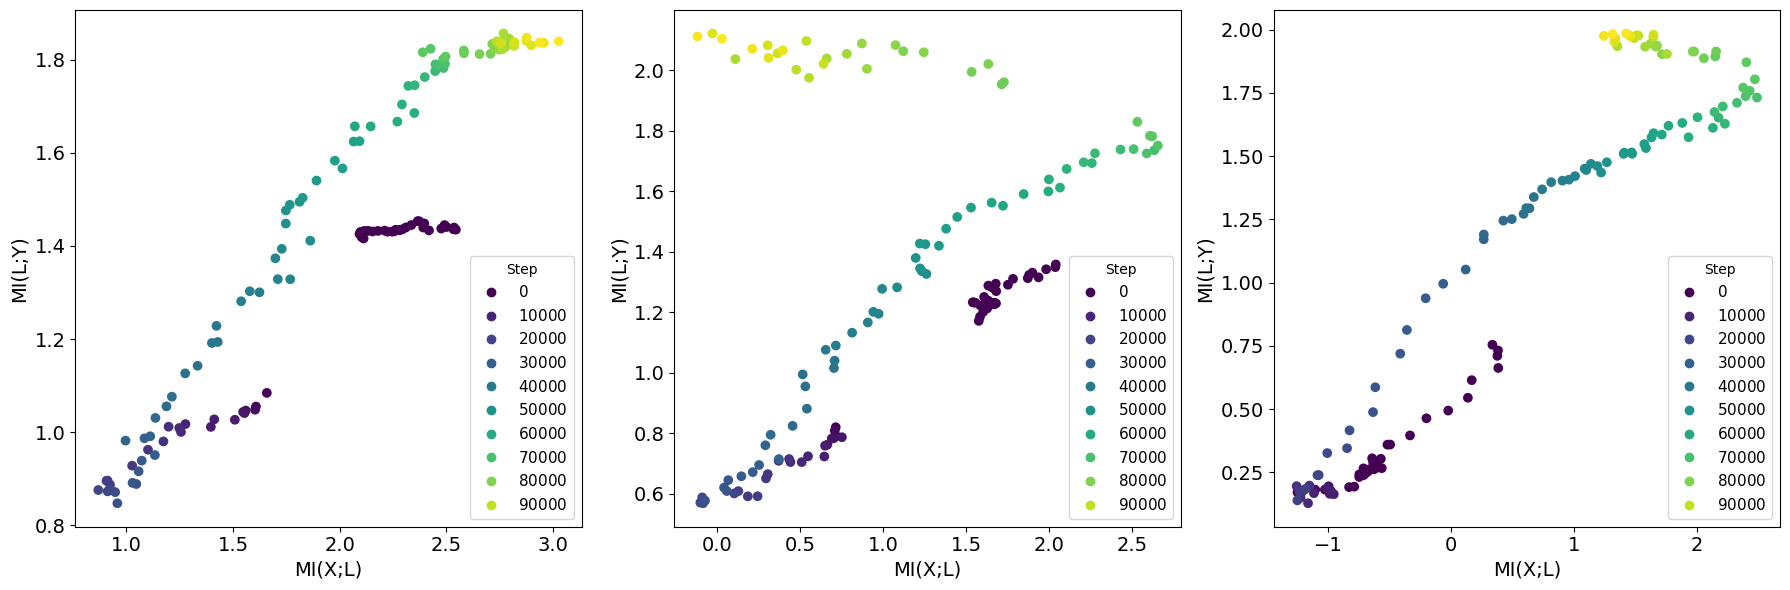

In [24]:
fig, axs2d = plt.subplots(1, 3, figsize=(18,6))

axs_rav = np.ravel(axs2d)

scat0 = axs_rav[0].scatter(data['mi_x_1'].values, data['mi_y_1'].values, c=data['step'].values)
legend2 = axs_rav[0].legend(*np.array(scat0.legend_elements()), loc="lower right", title="Step", fontsize=11)

scat1 = axs_rav[1].scatter(data['mi_x_2'].values, data['mi_y_2'].values, c=data['step'].values)
legend2 = axs_rav[1].legend(*np.array(scat1.legend_elements()), loc="lower right", title="Step", fontsize=11)

scat2 = axs_rav[2].scatter(data['mi_x_3'].values, data['mi_y_3'].values, c=data['step'].values)
legend2 = axs_rav[2].legend(*np.array(scat2.legend_elements()), loc="lower right", title="Step", fontsize=11)

for i in range(3):
    axs_rav[i].tick_params(axis='both', which='major', labelsize=14)
    axs_rav[i].set_xlabel("MI(X;L)", fontsize=14)
    axs_rav[i].set_ylabel("MI(L;Y)", fontsize=14)

# # xlim and ylim
# for ax_ in axs_rav:
#     ax_.set_xlim(-1.5, 3)
#     ax_.set_ylim(0, 2.5)

plt.tight_layout()
plt.show()

## Information Plane for Train data

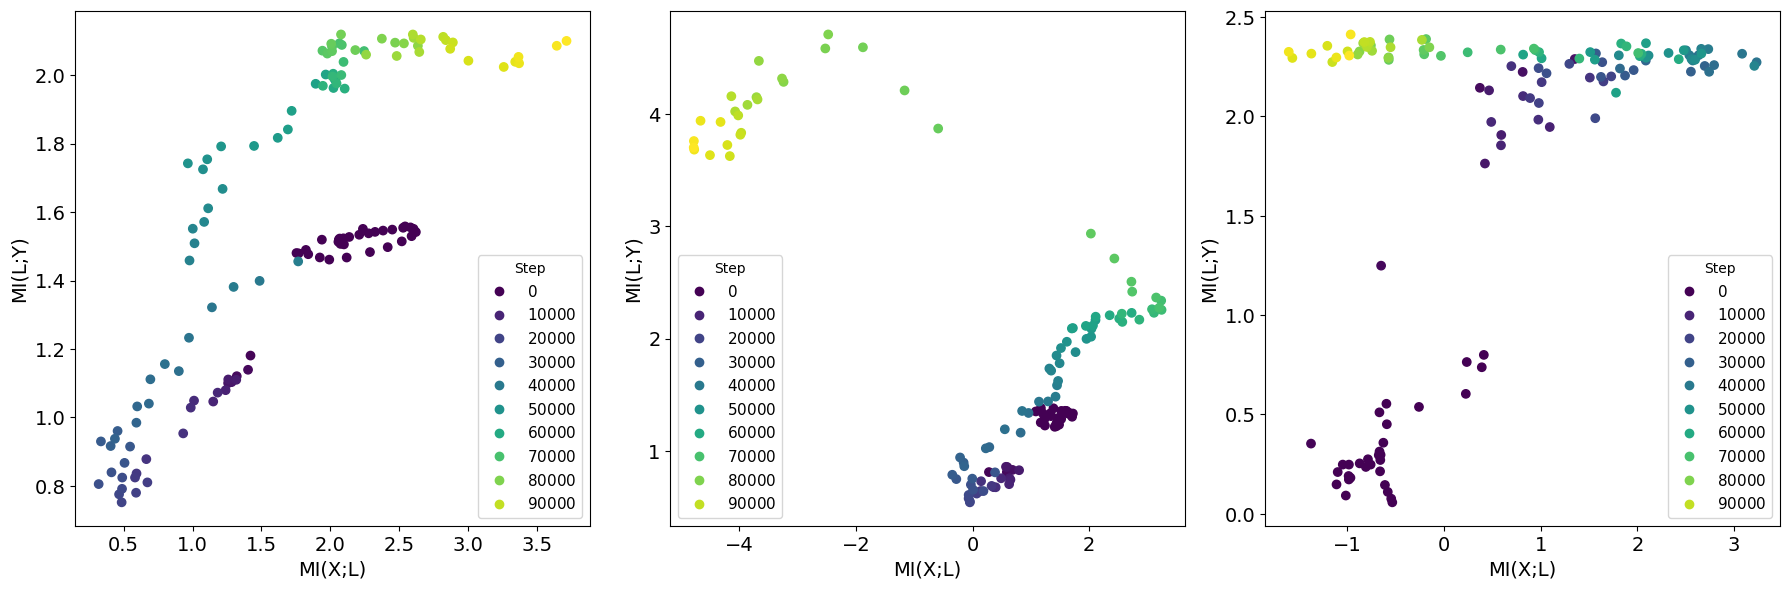

In [16]:
fig, axs2d = plt.subplots(1, 3, figsize=(18,6), )

axs_rav = np.ravel(axs2d)

scat0 = axs_rav[0].scatter(data['train_mi_x_1'].values, data['train_mi_y_1'].values, c=data['step'].values)
legend2 = axs_rav[0].legend(*np.array(scat0.legend_elements()), loc="lower right", title="Step", fontsize=11)

scat1 = axs_rav[1].scatter(data['train_mi_x_2'].values, data['train_mi_y_2'].values, c=data['step'].values)
legend2 = axs_rav[1].legend(*np.array(scat1.legend_elements()), loc="lower left", title="Step", fontsize=11)

scat2 = axs_rav[2].scatter(data['train_mi_x_3'].values, data['train_mi_y_3'].values, c=data['step'].values)
legend2 = axs_rav[2].legend(*np.array(scat2.legend_elements()), loc="lower right", title="Step", fontsize=11)

for i in range(3):
    axs_rav[i].tick_params(axis='both', which='major', labelsize=14)
    axs_rav[i].set_xlabel("MI(X;L)", fontsize=14)
    axs_rav[i].set_ylabel("MI(L;Y)", fontsize=14)

# # xlim and ylim
# for ax_ in axs_rav:
#     ax_.set_xlim(-6, )
#     ax_.set_ylim(0, 5)

plt.tight_layout()
plt.show()

## Equal limits

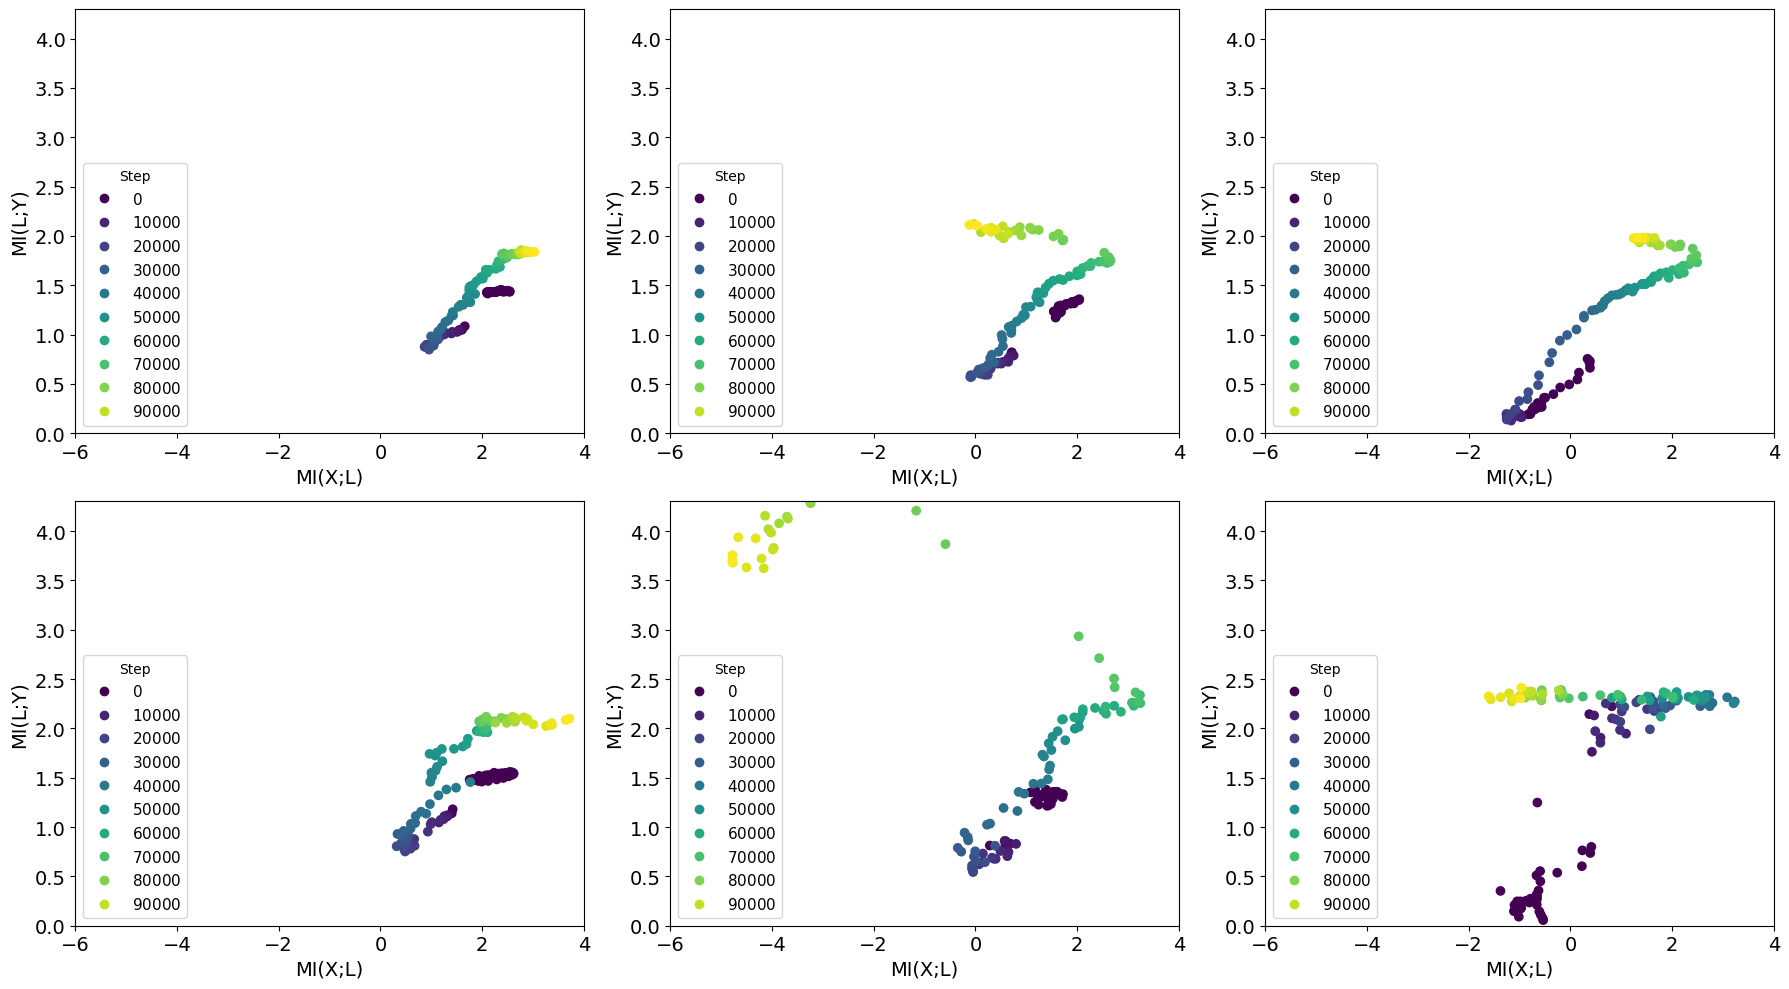

In [17]:
fig, axs2d = plt.subplots(2, 3, figsize=(18,10))

axs_rav = np.ravel(axs2d)

for i in range(3):
    scat0 = axs_rav[i].scatter(data[f'mi_x_{i+1}'].values, data[f'mi_y_{i+1}'].values, c=data['step'].values)
    axs_rav[i].legend(*np.array(scat0.legend_elements()), loc="lower left", title="Step", fontsize=11)
    
    scat0 = axs_rav[i+3].scatter(data[f'train_mi_x_{i+1}'].values, data[f'train_mi_y_{i+1}'].values, c=data['step'].values)
    axs_rav[i+3].legend(*np.array(scat0.legend_elements()), loc="lower left", title="Step", fontsize=11)

for i in range(6):
    axs_rav[i].tick_params(axis='both', which='major', labelsize=14)
    axs_rav[i].set_xlabel("MI(X;L)", fontsize=14)
    axs_rav[i].set_ylabel("MI(L;Y)", fontsize=14)

# xlim and ylim
for ax_ in axs_rav:
    ax_.set_xlim(-6, 4)
    ax_.set_ylim(0, 4.3)

plt.tight_layout()
plt.show()

## Accuracy and WN

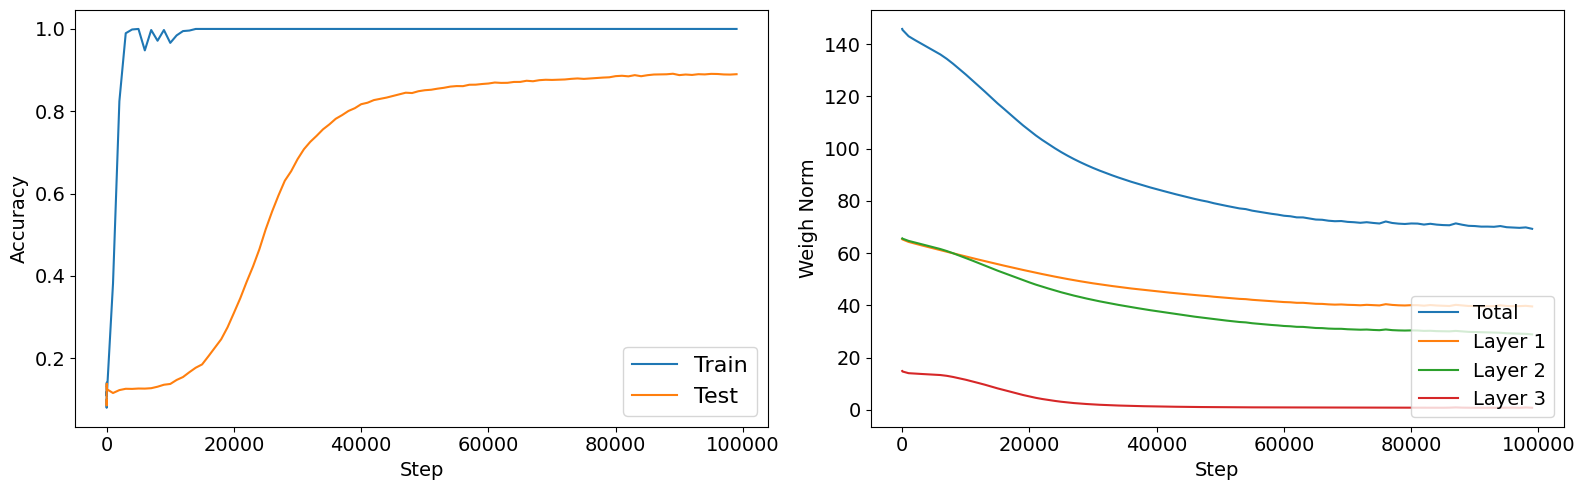

In [18]:
fig, axs2d = plt.subplots(1, 2, figsize=(16,5), )
axs_rav = np.ravel(axs2d)

sns.lineplot(
    data=data, 
    x=f"step", 
    y=f"acc_train",
    ax=axs_rav[0],
    label='Train'
)
sns.lineplot(
    data=data, 
    x=f"step", 
    y=f"acc_test",
    ax=axs_rav[0],
    label='Test'
)
axs_rav[0].legend(loc='lower right', fontsize=16)
axs_rav[0].tick_params(axis='both', which='major', labelsize=14)
axs_rav[0].set_xlabel("Step", fontsize=14)
axs_rav[0].set_ylabel("Accuracy", fontsize=14)
# axs_rav[0].set_xscale('log')

sns.lineplot(
    data=data, 
    x=f"step", 
    y=f"wn",
    ax=axs_rav[1],
    label='Total'
)
for i in range(1, 4):
    sns.lineplot(
        data=data, 
        x=f"step", 
        y=f"wn{i}",
        ax=axs_rav[1],
        label=f'Layer {i}'
    )
axs_rav[1].tick_params(axis='both', which='major', labelsize=14)
axs_rav[1].set_xlabel("Step", fontsize=14)
axs_rav[1].set_ylabel("Weigh Norm", fontsize=14)
axs_rav[1].legend(loc='lower right', fontsize=14)
# axs_rav[1].set_xscale('log')

plt.tight_layout()
plt.show()

## Test Accuracy and MI 

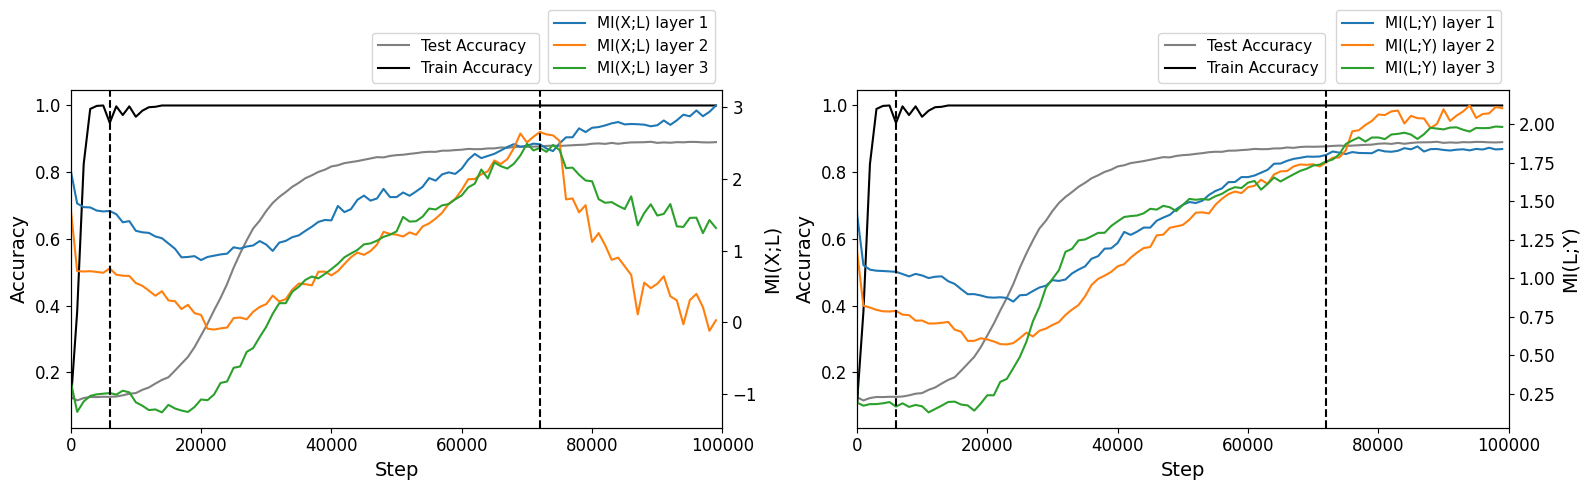

In [19]:
fig, axs2d = plt.subplots(1, 2, figsize=(16,5), )
axs_rav = np.ravel(axs2d)
vlinex_list = (6_000, 72_000)
legend_size = 11
tick_size = 12
label_size = 14
# ---------
# Accuracy
for i in range(2):
    sns.lineplot(
        data=data, 
        x=f"step", 
        y=f"acc_test",
        ax=axs_rav[i],
        color='grey',
        label='Test Accuracy'
    )
    sns.lineplot(
        data=data, 
        x=f"step", 
        y=f"acc_train",
        ax=axs_rav[i],
        color='black',
        label='Train Accuracy'
    )
# -----------
# MI(X;L)
ax0 = axs_rav[0].twinx()
for i in range(1,4):
    sns.lineplot(
        data=data, 
        x=f"step", 
        y=f"mi_x_{i}",
        ax=ax0,
        label=f'MI(X;L) layer {i}'
    )
# legend
axs_rav[0].legend(loc='lower right', fontsize=legend_size, bbox_to_anchor=(0.73, 1))
ax0.legend(loc='lower right', fontsize=legend_size, bbox_to_anchor=(1, 1))
# tick
axs_rav[0].tick_params(axis='both', which='major', labelsize=tick_size)
ax0.tick_params(axis='both', which='major', labelsize=tick_size)
# label
axs_rav[0].set_xlabel("Step", fontsize=label_size)
axs_rav[0].set_ylabel("Accuracy", fontsize=label_size)
ax0.set_ylabel("MI(X;L)", fontsize=label_size)
# xlim
axs_rav[0].set_xlim(0, 100_000)
# axs_rav[0].set_xscale('log')

# -----------
# MI(L;Y)
ax1 = axs_rav[1].twinx()
for i in range(1,4):
    sns.lineplot(
        data=data, 
        x=f"step", 
        y=f"mi_y_{i}",
        ax=ax1,
        label=f'MI(L;Y) layer {i}'
    )
# legend
axs_rav[1].legend(loc='lower right', fontsize=legend_size, bbox_to_anchor=(0.73, 1))
ax1.legend(loc='lower right', fontsize=legend_size, bbox_to_anchor=(1, 1))
# tick
axs_rav[1].tick_params(axis='both', which='major', labelsize=tick_size)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)
# label
axs_rav[1].set_xlabel("Step", fontsize=label_size)
axs_rav[1].set_ylabel("Accuracy", fontsize=label_size)
ax1.set_ylabel("MI(L;Y)", fontsize=label_size)
# xlim
axs_rav[1].set_xlim(0, 100_000)

# vertical lines
for ax_ in (ax0, ax1):
    for vlinex_ in vlinex_list:
        ax_.axvline(vlinex_, 0, 1000, c='black', linestyle='dashed')

plt.tight_layout()
plt.show()

## Train Accuracy and MI

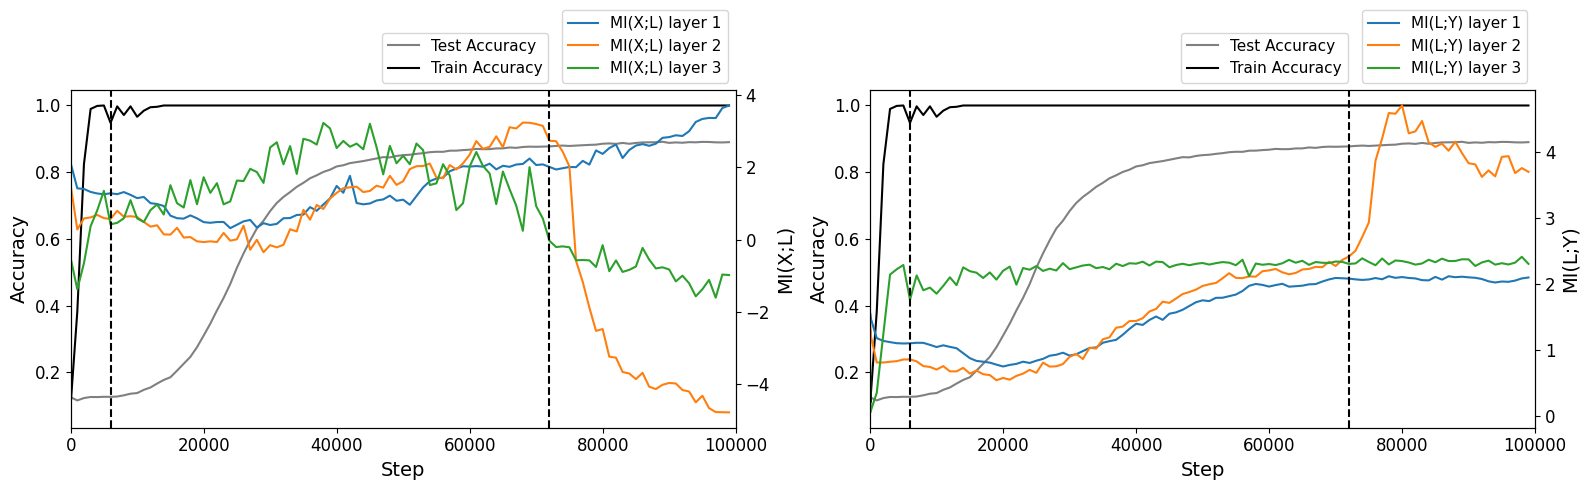

In [20]:
fig, axs2d = plt.subplots(1, 2, figsize=(16,5), )
axs_rav = np.ravel(axs2d)
vlinex_list = (6_000, 72_000)
legend_size = 11
tick_size = 12
label_size = 14
# ---------
# Accuracy
for i in range(2):
    sns.lineplot(
        data=data, 
        x=f"step", 
        y=f"acc_test",
        ax=axs_rav[i],
        color='grey',
        label='Test Accuracy'
    )
    sns.lineplot(
        data=data, 
        x=f"step", 
        y=f"acc_train",
        ax=axs_rav[i],
        color='black',
        label='Train Accuracy'
    )
# -----------
# MI(X;L)
ax0 = axs_rav[0].twinx()
for i in range(1,4):
    sns.lineplot(
        data=data, 
        x=f"step", 
        y=f"train_mi_x_{i}",
        ax=ax0,
        label=f'MI(X;L) layer {i}'
    )
# legend
axs_rav[0].legend(loc='lower right', fontsize=legend_size, bbox_to_anchor=(0.73, 1))
ax0.legend(loc='lower right', fontsize=legend_size, bbox_to_anchor=(1, 1))
# tick
axs_rav[0].tick_params(axis='both', which='major', labelsize=tick_size)
ax0.tick_params(axis='both', which='major', labelsize=tick_size)
# label
axs_rav[0].set_xlabel("Step", fontsize=label_size)
axs_rav[0].set_ylabel("Accuracy", fontsize=label_size)
ax0.set_ylabel("MI(X;L)", fontsize=label_size)
# xlim
axs_rav[0].set_xlim(0, 100_000)
# axs_rav[0].set_xscale('log')

# -----------
# MI(L;Y)
ax1 = axs_rav[1].twinx()
for i in range(1,4):
    sns.lineplot(
        data=data, 
        x=f"step", 
        y=f"train_mi_y_{i}",
        ax=ax1,
        label=f'MI(L;Y) layer {i}'
    )
# legend
axs_rav[1].legend(loc='lower right', fontsize=legend_size, bbox_to_anchor=(0.73, 1))
ax1.legend(loc='lower right', fontsize=legend_size, bbox_to_anchor=(1, 1))
# tick
axs_rav[1].tick_params(axis='both', which='major', labelsize=tick_size)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)
# label
axs_rav[1].set_xlabel("Step", fontsize=label_size)
axs_rav[1].set_ylabel("Accuracy", fontsize=label_size)
ax1.set_ylabel("MI(L;Y)", fontsize=label_size)
# xlim
axs_rav[1].set_xlim(0, 100_000)

# vertical lines
for ax_ in (ax0, ax1):
    for vlinex_ in vlinex_list:
        ax_.axvline(vlinex_, 0, 1000, c='black', linestyle='dashed')

plt.tight_layout()
plt.show()